In [ ]:
!pip install scikit-learn scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.5 MB/s eta 0:00:00


In [ ]:
#imports
import pandas as pd
import imblearn
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import missingno as mno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## original raw data was in four different files without feature names
## reads raw data files and feature file from drive
df_1 = pd.read_csv('/content/drive/MyDrive/JOB-ML/UNSW-NB15_1.csv')
df_2 = pd.read_csv('/content/drive/MyDrive/JOB-ML/UNSW-NB15_2.csv')
df_3 = pd.read_csv('/content/drive/MyDrive/JOB-ML/UNSW-NB15_3.csv')
df_4 = pd.read_csv('/content/drive/MyDrive/JOB-ML/UNSW-NB15_4.csv')
df_features = pd.read_csv('/content/drive/MyDrive/JOB-ML/NUSW-NB15_features.csv', encoding='cp1252')

<ipython-input-3-da8631123dbd>:1: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1 = pd.read_csv('/content/drive/MyDrive/JOB-ML/UNSW-NB15_1.csv')
<ipython-input-3-da8631123dbd>:2: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2 = pd.read_csv('/content/drive/MyDrive/JOB-ML/UNSW-NB15_2.csv')


In [ ]:
# Extract the feature names from df_features
feature_names = df_features['Name'].tolist()
# Assign the feature names to df_1, df_2 , df_3,df_4 as column names
df_1.columns = feature_names
df_2.columns = feature_names
df_3.columns = feature_names
df_4.columns = feature_names

In [ ]:
# concatenating df1,df2,df3,df4 along rows
# produces one final dataframe
df_final = pd.concat([df_1, df_2,df_3,df_4], axis=0)
df_final

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
1,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
2,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
3,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0
4,59.166.0.0,32119,149.171.126.9,111,udp,CON,0.078339,568,312,31,...,0,2,4,2,3,1,1,2,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440038,59.166.0.5,33094,149.171.126.7,43433,tcp,FIN,0.087306,320,1828,31,...,,1,2,3,3,1,1,3,NaN,0
440039,59.166.0.7,20848,149.171.126.4,21,tcp,CON,0.365058,456,346,31,...,2,2,2,2,2,2,2,2,NaN,0
440040,59.166.0.3,21511,149.171.126.9,21,tcp,CON,6.335154,1802,2088,31,...,2,2,2,4,2,2,2,2,NaN,0
440041,59.166.0.9,35433,149.171.126.0,80,tcp,CON,2.200934,3498,166054,31,...,,1,1,2,4,2,2,2,NaN,0


Pre processing of data

Imbalanced data set

In [ ]:
#removes extra spaces from column attack_cat
df_final['attack_cat'] = df_final['attack_cat'].str.strip()
df_final['attack_cat'] = df_final['attack_cat'].replace({'Backdoors': 'Backdoors', 'Backdoor': 'Backdoors'})

In [ ]:
# Update the 'attack_cat' column with Normal where label is 0
df_final.loc[df_final['Label'] == 0, 'attack_cat'] = 'Normal'

Data Visualization

1- Binary

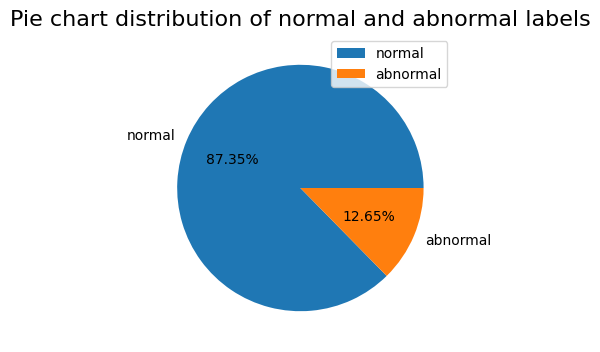

In [ ]:
## Pie chart distribution of normal and abnormal classes
plt.figure(figsize=(4,4))
plt.pie(df_final.Label.value_counts(),labels=['normal','abnormal'],autopct='%0.2f%%')
plt.title("Pie chart distribution of normal and abnormal labels",fontsize=16)
plt.legend()
plt.show()

2- Multi-Class

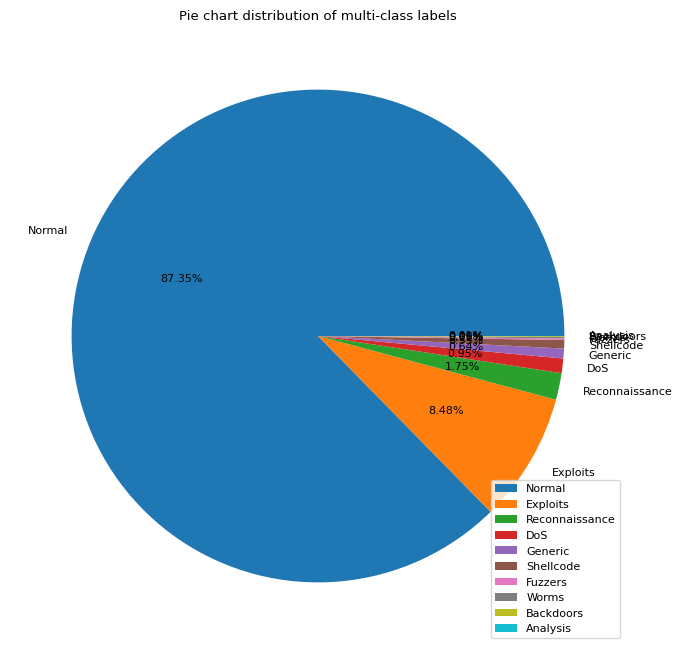

In [ ]:
## pie chart distribution of normal and all other abnormal classes
plt.figure(figsize=(8,8))
plt.pie(df_final.attack_cat.value_counts(),labels=df_final.attack_cat.unique(),autopct='%0.2f%%')
plt.title('Pie chart distribution of multi-class labels')
plt.legend(loc='best')
plt.show()

In [ ]:
# Calculate the class distribution of the dataset in percentage
class_distribution = df_final['attack_cat'].value_counts(normalize=True) * 100

# Display the class distribution
print(class_distribution)

Normal            87.351277
Generic            8.483360
Exploits           1.752923
Fuzzers            0.954551
DoS                0.643808
Reconnaissance     0.550660
Analysis           0.105392
Backdoors          0.091691
Shellcode          0.059487
Worms              0.006850
Name: attack_cat, dtype: float64


In [ ]:
df_final

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,Normal,0
1,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,Normal,0
2,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,Normal,0
3,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,Normal,0
4,59.166.0.0,32119,149.171.126.9,111,udp,CON,0.078339,568,312,31,...,0,2,4,2,3,1,1,2,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440038,59.166.0.5,33094,149.171.126.7,43433,tcp,FIN,0.087306,320,1828,31,...,,1,2,3,3,1,1,3,Normal,0
440039,59.166.0.7,20848,149.171.126.4,21,tcp,CON,0.365058,456,346,31,...,2,2,2,2,2,2,2,2,Normal,0
440040,59.166.0.3,21511,149.171.126.9,21,tcp,CON,6.335154,1802,2088,31,...,2,2,2,4,2,2,2,2,Normal,0
440041,59.166.0.9,35433,149.171.126.0,80,tcp,CON,2.200934,3498,166054,31,...,,1,1,2,4,2,2,2,Normal,0


In [ ]:
#undersampling

# Separate the "normal" class from the rest of the data
normal_data = df_final[df_final['attack_cat'] == 'Normal']
other_data = df_final[df_final['attack_cat'] != 'Normal']

# Reduce the number of instances in the "Normal" class by 50%
reduced_normal_data = normal_data.sample(frac=0.5, random_state=42)

# Combine the reduced "Normal" data and the other data
final_data = pd.concat([reduced_normal_data, other_data])

# Print the class distribution of the final data
class_distribution = final_data['attack_cat'].value_counts(normalize=True) * 100
print(class_distribution)


Normal            77.543069
Generic           15.061618
Exploits           3.112193
Fuzzers            1.694739
DoS                1.143036
Reconnaissance     0.977659
Analysis           0.187116
Backdoors          0.162792
Shellcode          0.105615
Worms              0.012162
Name: attack_cat, dtype: float64


In [ ]:
final_data.dtypes

In [ ]:
# List of columns to convert
columns_to_convert = ['sport', 'dsport', 'ct_ftp_cmd']

# Convert each column from object to numeric data type
for column in columns_to_convert:
    final_data[column] = pd.to_numeric(final_data[column], errors='coerce')

In [ ]:
final_data.dtypes

srcip                object
sport               float64
dstip                object
dsport              float64
proto                object
state                object
dur                 float64
sbytes                int64
dbytes                int64
sttl                  int64
dttl                  int64
sloss                 int64
dloss                 int64
service              object
Sload               float64
Dload               float64
Spkts                 int64
Dpkts                 int64
swin                  int64
dwin                  int64
stcpb                 int64
dtcpb                 int64
smeansz               int64
dmeansz               int64
trans_depth           int64
res_bdy_len           int64
Sjit                float64
Djit                float64
Stime                 int64
Ltime                 int64
Sintpkt             float64
Dintpkt             float64
tcprtt              float64
synack              float64
ackdat              float64
is_sm_ips_ports     

In [ ]:
#drop columns having categorical/nominal data bcz those are incompatible
df = final_data.drop(['srcip','dstip','proto', 'service','state'], axis=1)

In [ ]:
df

,sport,dsport,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,Sload,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
512413,47439.0,53.0,0.000004,264,0,60,0,0,0,2.640000e+08,...,NaN,29,29,22,22,22,22,29,Normal,0
440212,35877.0,80.0,1.368633,19722,1087890,31,29,2,370,1.149702e+05,...,NaN,1,3,4,1,1,1,3,Normal,0
82578,37951.0,12319.0,0.002692,320,1956,31,29,1,2,7.934621e+05,...,NaN,3,3,5,7,1,1,5,Normal,0
304056,14284.0,40769.0,0.100885,1784,33850,31,29,1,12,1.371066e+05,...,0.0,8,2,1,4,1,1,1,Normal,0
429521,9167.0,21.0,3.314790,2934,3742,31,29,11,15,6.945840e+03,...,1.0,1,1,15,12,1,1,5,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440023,47439.0,53.0,0.000001,114,0,254,0,0,0,4.560000e+08,...,NaN,15,15,15,15,15,15,15,Generic,1
440024,17293.0,110.0,0.942984,574,676,62,252,5,6,4.470914e+03,...,NaN,2,1,2,4,2,2,2,Exploits,1
440025,33654.0,80.0,2.579405,269883,1300,62,252,103,1,8.330169e+05,...,NaN,2,1,2,4,2,2,2,DoS,1
440026,33654.0,80.0,2.579405,269883,1300,62,252,103,1,8.330169e+05,...,NaN,1,1,2,4,2,2,2,DoS,1


In [ ]:
#check if there are any missing values
df.isnull().any().any()

True

In [ ]:
#counts the number of missing values in each column
for column in df.columns:
    empty_count = df[column].isna().sum()
    if empty_count != 0:
      print(f"Column '{column}': {empty_count} empty cells")

Column 'sport': 6 empty cells
Column 'dsport': 134 empty cells
Column 'ct_flw_http_mthd': 815481 empty cells
Column 'is_ftp_login': 863431 empty cells
Column 'ct_ftp_cmd': 863431 empty cells


Regression imputation

In [ ]:
# drop the categorical column of attack_cat
df_regression = df.drop('attack_cat', axis=1)

In [ ]:
df_regression

<Axes: >

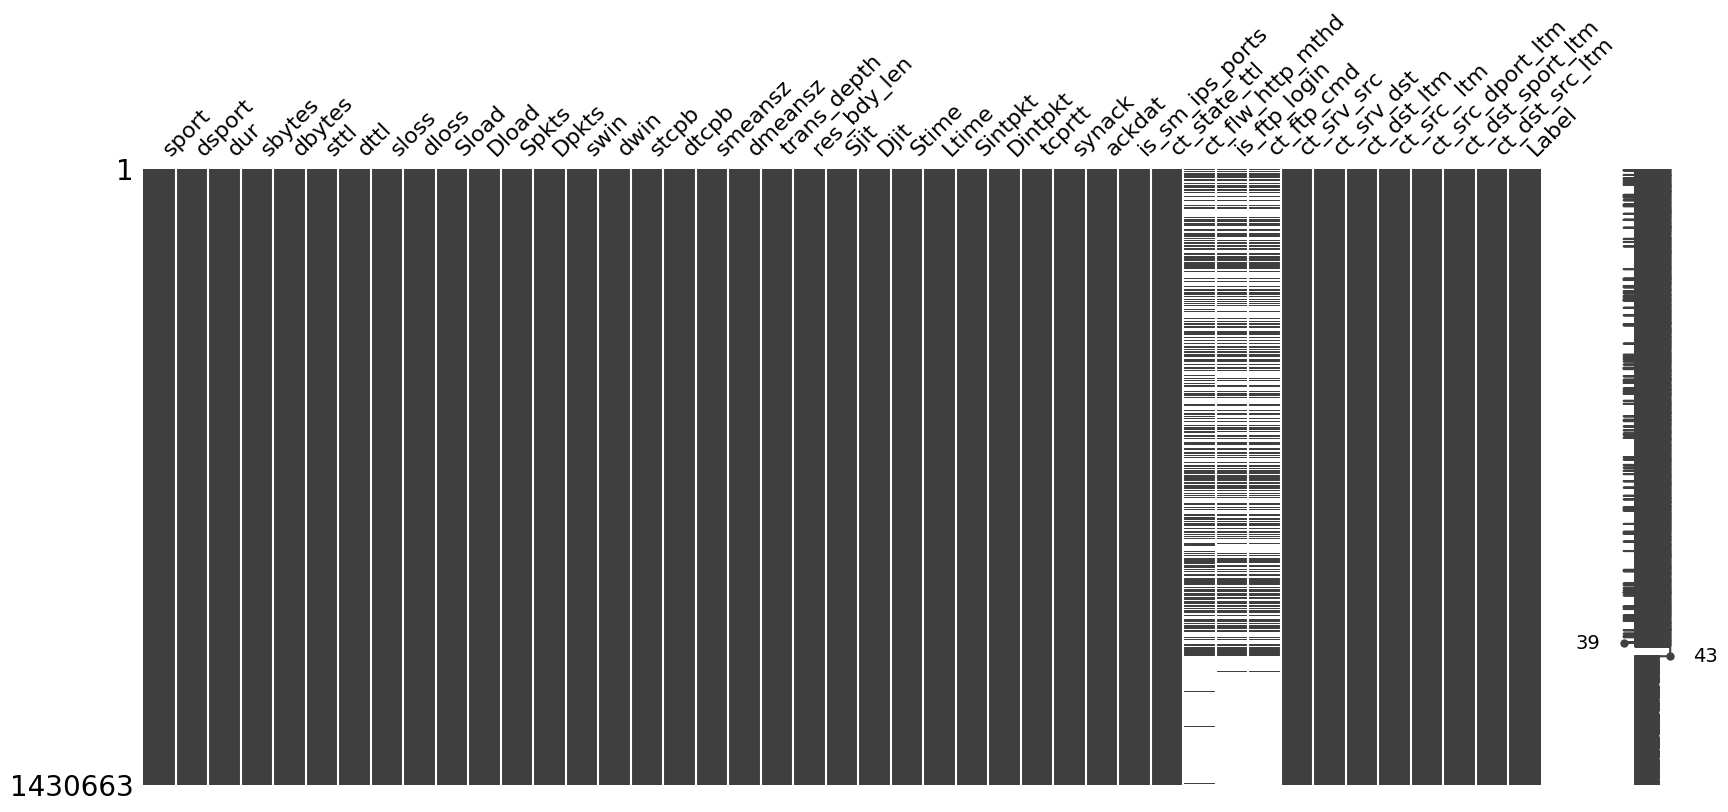

In [ ]:
mno.matrix(df_regression, figsize = (20, 8))

In [ ]:
# Create an instance of IterativeImputer with LinearRegression as the estimator
imputer = IterativeImputer(estimator=LinearRegression())

# Perform imputation on the DataFrame
imputed_data = imputer.fit_transform(df_regression)

# Convert the imputed data back to a DataFrame
imputed_df = pd.DataFrame(imputed_data, columns=df_regression.columns)

In [ ]:
imputed_df.isnull().any().any()

False

In [ ]:
imputed_df

,sport,dsport,dur,dttl,sloss,dloss,Sload,Dload,Spkts,Dpkts,...,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,Label
0,47439.0,53.0,0.000004,0.0,0.0,0.0,2.640000e+08,0.000000e+00,2.0,0.0,...,0.416769,0.671370,29.0,29.0,22.0,22.0,22.0,22.0,29.0,0.0
1,35877.0,80.0,1.368633,29.0,2.0,370.0,1.149702e+05,6.350465e+06,370.0,746.0,...,0.538826,0.364746,1.0,3.0,4.0,1.0,1.0,1.0,3.0,0.0
2,37951.0,12319.0,0.002692,29.0,1.0,2.0,7.934621e+05,5.087667e+06,6.0,8.0,...,0.566385,0.436359,3.0,3.0,5.0,7.0,1.0,1.0,5.0,0.0
3,14284.0,40769.0,0.100885,29.0,1.0,12.0,1.371066e+05,2.607563e+06,32.0,35.0,...,0.000000,0.000000,8.0,2.0,1.0,4.0,1.0,1.0,1.0,0.0
4,9167.0,21.0,3.314790,29.0,11.0,15.0,6.945840e+03,8.864514e+03,52.0,54.0,...,1.000000,1.000000,1.0,1.0,15.0,12.0,1.0,1.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1430658,47439.0,53.0,0.000001,0.0,0.0,0.0,4.560000e+08,0.000000e+00,2.0,0.0,...,0.490527,0.535811,15.0,15.0,15.0,15.0,15.0,15.0,15.0,1.0
1430659,17293.0,110.0,0.942984,252.0,5.0,6.0,4.470914e+03,5.259898e+03,12.0,12.0,...,0.589015,0.429452,2.0,1.0,2.0,4.0,2.0,2.0,2.0,1.0
1430660,33654.0,80.0,2.579405,252.0,103.0,1.0,8.330169e+05,3.898573e+03,208.0,30.0,...,0.467984,0.238979,2.0,1.0,2.0,4.0,2.0,2.0,2.0,1.0
1430661,33654.0,80.0,2.579405,252.0,103.0,1.0,8.330169e+05,3.898573e+03,208.0,30.0,...,0.468905,0.241184,1.0,1.0,2.0,4.0,2.0,2.0,2.0,1.0


In [ ]:
## drop the categorical data from the dataframe
imputed_df = imputed_df.drop(['sbytes','sttl','ct_state_ttl','dbytes'],axis=1)

In [ ]:
# reset the index column in df_attack dataframe
df_attack =df['attack_cat'].reset_index()

In [ ]:
#drops the index column
df_attack = df_attack.drop(['index'],axis=1)

In [ ]:
#concatenate the attack category column with the imputed dataframe
final_regression_df = pd.concat([imputed_df, df_attack], axis=1)

In [ ]:
final_regression_df

,sport,dsport,dur,dttl,sloss,dloss,Sload,Dload,Spkts,Dpkts,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,Label,attack_cat
0,47439.0,53.0,0.000004,0.0,0.0,0.0,2.640000e+08,0.000000e+00,2.0,0.0,...,0.671370,29.0,29.0,22.0,22.0,22.0,22.0,29.0,0.0,Normal
1,35877.0,80.0,1.368633,29.0,2.0,370.0,1.149702e+05,6.350465e+06,370.0,746.0,...,0.364746,1.0,3.0,4.0,1.0,1.0,1.0,3.0,0.0,Normal
2,37951.0,12319.0,0.002692,29.0,1.0,2.0,7.934621e+05,5.087667e+06,6.0,8.0,...,0.436359,3.0,3.0,5.0,7.0,1.0,1.0,5.0,0.0,Normal
3,14284.0,40769.0,0.100885,29.0,1.0,12.0,1.371066e+05,2.607563e+06,32.0,35.0,...,0.000000,8.0,2.0,1.0,4.0,1.0,1.0,1.0,0.0,Normal
4,9167.0,21.0,3.314790,29.0,11.0,15.0,6.945840e+03,8.864514e+03,52.0,54.0,...,1.000000,1.0,1.0,15.0,12.0,1.0,1.0,5.0,0.0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1430658,47439.0,53.0,0.000001,0.0,0.0,0.0,4.560000e+08,0.000000e+00,2.0,0.0,...,0.535811,15.0,15.0,15.0,15.0,15.0,15.0,15.0,1.0,Generic
1430659,17293.0,110.0,0.942984,252.0,5.0,6.0,4.470914e+03,5.259898e+03,12.0,12.0,...,0.429452,2.0,1.0,2.0,4.0,2.0,2.0,2.0,1.0,Exploits
1430660,33654.0,80.0,2.579405,252.0,103.0,1.0,8.330169e+05,3.898573e+03,208.0,30.0,...,0.238979,2.0,1.0,2.0,4.0,2.0,2.0,2.0,1.0,DoS
1430661,33654.0,80.0,2.579405,252.0,103.0,1.0,8.330169e+05,3.898573e+03,208.0,30.0,...,0.241184,1.0,1.0,2.0,4.0,2.0,2.0,2.0,1.0,DoS


In [ ]:
#save regression imputed pre processed dataframe on google drive
final_regression_df.to_csv('/content/drive/MyDrive/JOB-ML/Binary Classification/regression imputation/pre-processed_regression_DF.csv', index=False)

Mean imputation

In [ ]:
#fill those missing values with mean imputation
df = df.fillna(df.mean())
df.isnull().any().any()

<ipython-input-16-5c46ba2fef32>:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = df.fillna(df.mean())


False

In [ ]:
df_features = df.iloc[:, 0:-2] # selects all columns except last two
df_target = df.iloc[:, -1:] #selects last label column

In [ ]:
## use random forest classifier for feature importance

model = RandomForestClassifier(n_estimators = 100) # initialize randome Forest Model

# fits model on the extracted dataframe features and target column
model.fit(df_features,df_target)

<ipython-input-19-19fb422d0498>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(df_features,df_target)


RandomForestClassifier()

In [ ]:
# feature importance calculated by the model is assigned to the variable
importances = model.feature_importances_

<Figure size 2000x800 with 0 Axes>

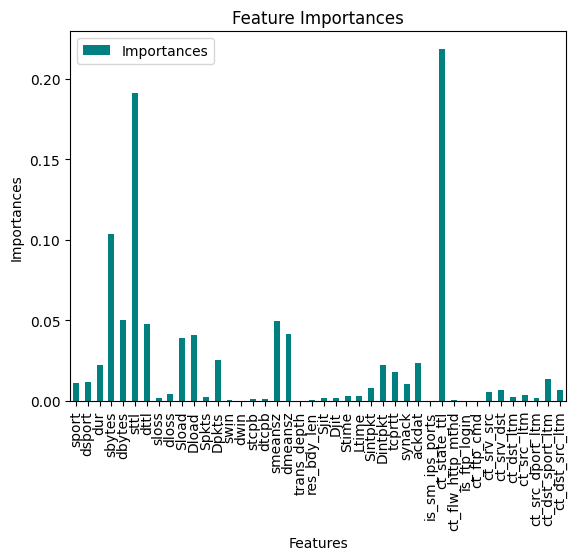

In [ ]:
#created a dataframe with two columsn
feature_df = pd.DataFrame({'Features' : pd.DataFrame(df_features).columns , 'Importances' : importances})

# Set 'Features' column as the index
feature_df.set_index("Features", inplace=True)

# Setting the figure size to 20 by 8 inches
plt.figure(figsize=(20, 8))

# Plot the bar graph
feature_df.plot.bar(color='teal')

# Add labels and title
plt.xlabel('Features')
plt.ylabel('Importances')
plt.title('Feature Importances')

# Set the x-axis tick positions and labels
plt.xticks(range(len(feature_df.index)), feature_df.index)

# Display the plot
plt.show()

<Figure size 2000x800 with 0 Axes>

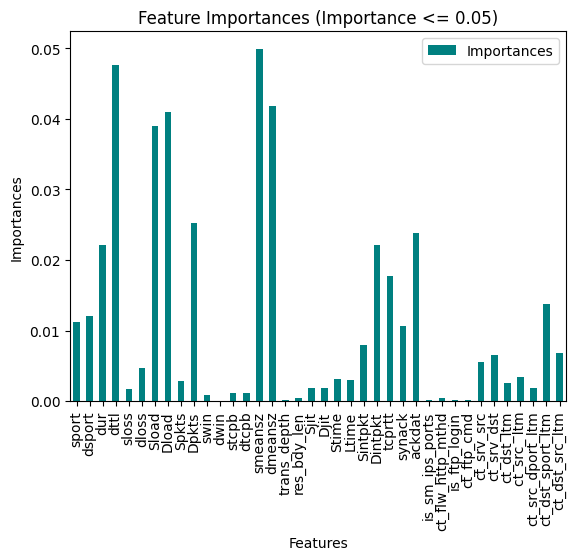

In [ ]:
# assigns threshold value to 0.05
threshold = 0.05

#extracts all features whose importance is less than the threshold value
filtered_df = feature_df.loc[feature_df['Importances'] <= threshold]

# Setting the figure size to 20 by 8 inches
plt.figure(figsize=(20, 8))

# Plot the bar graph
filtered_df.plot.bar(color='teal')

# Add labels and title
plt.xlabel('Features')
plt.ylabel('Importances')
plt.title('Feature Importances (Importance <= 0.05)')

# Set the x-axis tick positions and labels
plt.xticks(range(len(filtered_df.index)), filtered_df.index)

# Display the plot
plt.show()

In [ ]:
filtered_df.shape

(38, 1)

In [ ]:
# drops columns with high threshold value
processed_df = df.drop(['sbytes','sttl','ct_state_ttl','dbytes'],axis=1)

In [ ]:
#save mean imputed pre processed dataframe on google drive
processed_df.to_csv('/content/drive/MyDrive/JOB-ML/Binary Classification/mean imputation/pre-processed_DF.csv', index=False)

In [ ]:
#read mean imputed pre processed df from google drive
df = pd.read_csv('/content/drive/MyDrive/JOB-ML/Binary Classification/mean imputation/pre-processed_DF.csv')

In [ ]:
df

,sport,dsport,dur,dttl,sloss,dloss,Sload,Dload,Spkts,Dpkts,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,47439.0,53.0,0.000004,0,0,0,2.640000e+08,0.000000e+00,2,0,...,0.047728,29,29,22,22,22,22,29,Normal,0
1,35877.0,80.0,1.368633,29,2,370,1.149702e+05,6.350465e+06,370,746,...,0.047728,1,3,4,1,1,1,3,Normal,0
2,37951.0,12319.0,0.002692,29,1,2,7.934621e+05,5.087667e+06,6,8,...,0.047728,3,3,5,7,1,1,5,Normal,0
3,14284.0,40769.0,0.100885,29,1,12,1.371066e+05,2.607563e+06,32,35,...,0.000000,8,2,1,4,1,1,1,Normal,0
4,9167.0,21.0,3.314790,29,11,15,6.945840e+03,8.864514e+03,52,54,...,1.000000,1,1,15,12,1,1,5,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1430658,47439.0,53.0,0.000001,0,0,0,4.560000e+08,0.000000e+00,2,0,...,0.047728,15,15,15,15,15,15,15,Generic,1
1430659,17293.0,110.0,0.942984,252,5,6,4.470914e+03,5.259898e+03,12,12,...,0.047728,2,1,2,4,2,2,2,Exploits,1
1430660,33654.0,80.0,2.579405,252,103,1,8.330169e+05,3.898573e+03,208,30,...,0.047728,2,1,2,4,2,2,2,DoS,1
1430661,33654.0,80.0,2.579405,252,103,1,8.330169e+05,3.898573e+03,208,30,...,0.047728,1,1,2,4,2,2,2,DoS,1


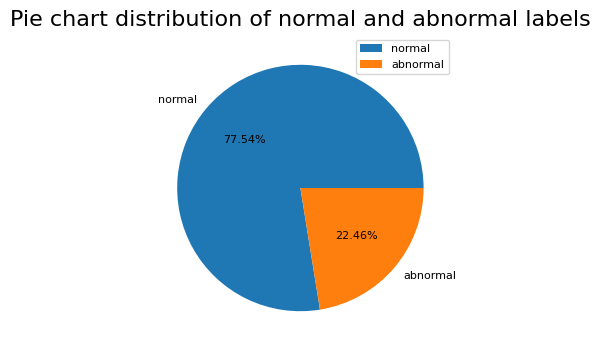

In [ ]:
# Pie chart distrubution of mean imputed pre processed dataframe
plt.figure(figsize=(4,4))
plt.pie(df.Label.value_counts(),labels=['normal','abnormal'],autopct='%0.2f%%')
plt.title("Pie chart distribution of normal and abnormal labels",fontsize=16)
plt.legend()
plt.show()

In [ ]:
df.dtypes

sport               float64
dsport              float64
dur                 float64
dttl                  int64
sloss                 int64
dloss                 int64
Sload               float64
Dload               float64
Spkts                 int64
Dpkts                 int64
swin                  int64
dwin                  int64
stcpb                 int64
dtcpb                 int64
smeansz               int64
dmeansz               int64
trans_depth           int64
res_bdy_len           int64
Sjit                float64
Djit                float64
Stime                 int64
Ltime                 int64
Sintpkt             float64
Dintpkt             float64
tcprtt              float64
synack              float64
ackdat              float64
is_sm_ips_ports       int64
ct_flw_http_mthd    float64
is_ftp_login        float64
ct_ftp_cmd          float64
ct_srv_src            int64
ct_srv_dst            int64
ct_dst_ltm            int64
ct_src_ ltm           int64
ct_src_dport_ltm    

Binary Classification Using Mean Imputed Data

Ranfom Forest

In [ ]:
# assign features to x variable
x = df.iloc[:, 0:-2]

# assign binary class(last column) to y variable
y = df.iloc[:, -1:].values.ravel()

# Splits data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [ ]:
# define param space for hyper parameter tuning
param_space = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt'],
    'min_samples_split': [2, 5, 10]
}

In [ ]:
#define the RF model
model = RandomForestClassifier()

# uses bayesSearch to find optimal hyper parameters
bayes_search = BayesSearchCV(model, param_space, n_iter=10, cv=2, random_state=42)

In [ ]:
# fit the data into the bayes search algorithm
bayes_search.fit(x, y)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

BayesSearchCV(cv=2, estimator=RandomForestClassifier(), n_iter=10,
              random_state=42,
              search_spaces={'criterion': ['gini', 'entropy'],
                             'max_features': ['auto', 'sqrt'],
                             'min_samples_split': [2, 5, 10],
                             'n_estimators': [100, 200, 300]})

In [ ]:
best_params = bayes_search.best_params_
best_score = bayes_search.best_score_

In [ ]:
n_estimators = best_params['n_estimators']
criterion = best_params['criterion']
max_features = best_params['max_features']
min_samples_split = best_params['min_samples_split']


In [ ]:
print('n_estimators =', n_estimators, '\n', 'criterion =', criterion,'\n','max_features =',max_features , '\n','min_samples_split =',min_samples_split)


n_estimators = 200 
 criterion = entropy 
 max_features = sqrt 
 min_samples_split = 5


In [ ]:
# use optimal hyperparameters to train the model
best_rf_model = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                                       criterion=best_params['criterion'],
                                       max_features=best_params['max_features'],
                                       min_samples_split=best_params['min_samples_split'])

# Train the model using the training data
best_rf_model.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', min_samples_split=5,
                       n_estimators=200)

In [ ]:
# Make predictions on the test data
predictions = best_rf_model.predict(x_test)

# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

# Print the evaluation metrics
print("Accuracy:", accuracy*100)
print("Precision:", precision*100)
print("Recall:", recall*100)
print("F1-score:", f1*100)

Accuracy: 0.9943278125906484
Precision: 0.9844790382244143
Recall: 0.99044798337701
F1-score: 0.9874544906430442


SVM

In [ ]:
# Creates an instance of the MinMaxScaler for Normalization
scaler = MinMaxScaler()

x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train.values), columns=x_train.columns)
x_test_scaled = pd.DataFrame(scaler.fit_transform(x_test.values), columns=x_test.columns)

Non-Linear

In [ ]:
#Define svm model with radial base kernel function
svm_model = SVC(kernel='rbf')
svm_model.fit(x_train_scaled, y_train)

SVC()

In [ ]:
#Make predictions on the test data
y_pred = svm_model.predict(x_test_scaled)

#calculate the accuracy of the non linear svm model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9811870703484045


Linear

In [ ]:
# Define the SVM model
model = LinearSVC(dual=False)

# Define the parameter grid
param_space = {
    'tol': (1e-15, 1e-5, 'log-uniform'),
    'C': (0.1, 10.0, 'log-uniform')
}

In [ ]:
# use bayes Search for hyper parameter tuning for the SVM model
bayes_search = BayesSearchCV(model, param_space, n_iter=10, cv=10, random_state=42)

In [ ]:
bayes_search.fit(x, y)

BayesSearchCV(cv=10, estimator=LinearSVC(dual=False), n_iter=10,
              random_state=42,
              search_spaces={'C': (0.1, 10.0, 'log-uniform'),
                             'tol': (1e-15, 1e-05, 'log-uniform')})

In [ ]:
best_params = bayes_search.best_params_
best_score = bayes_search.best_score_

In [ ]:
penalty = 'l1'
loss = 'squared_hinge'
tol = best_params['tol']
C = best_params['C']

In [ ]:
print('penalty =', penalty, '\n', 'loss =', loss,'\n','tol =',tol , '\n','C =',C)

penalty = l1 
 loss = squared_hinge 
 tol = 2.4004455788496022e-11 
 C = 3.9728931339630273


In [ ]:
# Create the LinearSVC model with the best hyperparameters
best_svm_model = LinearSVC(penalty=penalty,tol=tol ,C=C,loss=loss ,dual=False)
# Train the best model using the training data
best_svm_model.fit(x_train_scaled, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=3.9728931339630273, dual=False, penalty='l1',
          tol=2.4004455788496022e-11)

In [ ]:
# Make predictions on the test data
predictions = best_svm_model.predict(x_test_scaled)

# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9090667626593227
Precision: 0.7322114107733539
Recall: 0.940501480872707
F1-score: 0.8233880656788145


ANN

In [ ]:
x = df.iloc[:, 0:-2].values
y = df.iloc[:, -1:].values.ravel()

# split the data into testing and training sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
# Creates an instance of the MinMaxScaler
scaler = MinMaxScaler()

# Fits the scaler on the training data and transforms it
x_train_scaled = scaler.fit_transform(x_train)

# Fits the scaler on the testing data and transforms it
x_test_scaled = scaler.transform(x_test)

In [ ]:
# Convert the data to PyTorch tensors
x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test_scaled , dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


In [ ]:
# Create a PyTorch DataLoader for training and test sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
# Define the ANN model
class ANN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define hyperparameters
input_size = x_train.shape[1]
hidden_size = 100
num_classes = len(pd.unique(y_train))
learning_rate = 0.001
num_epochs = 5

# Create the ANN model
model = ANN(input_size, hidden_size, num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the training loss after every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/5], Loss: 0.0137
Epoch [2/5], Loss: 0.0001
Epoch [3/5], Loss: 0.0021
Epoch [4/5], Loss: 0.0019
Epoch [5/5], Loss: 0.0196


In [ ]:
# Evaluation on training set
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Training Accuracy: {accuracy:.2f}%')

Training Accuracy: 98.84%


In [ ]:
# Evaluation on test set
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    labels_cm = []
    predicted_cm =[]
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        labels_cm.extend(labels.tolist())
        predicted_cm.extend(predicted.tolist())

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 98.85%


CONFUSION MATRIX

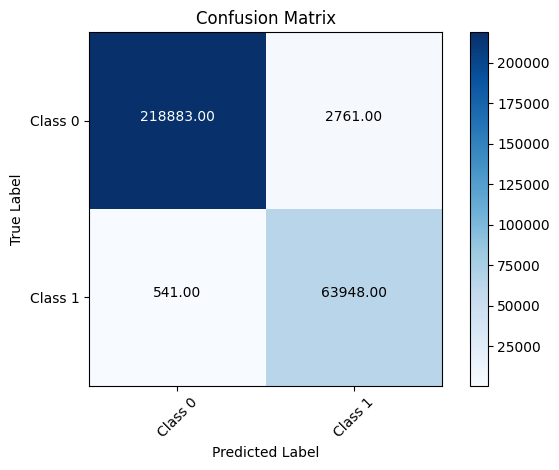

In [ ]:
y_true = np.array(labels_cm)
y_pred = np.array(predicted_cm)


# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = ['Class 0', 'Class 1']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Format the text inside the plot
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()
